# Kaggle Contest - Dog Breed Identification

Determine the breed of a dog in an image.

数据集特性

- 来自 Stanford Dog Dataset, 本身也是 ImageNet DataSet 的子集。http://vision.stanford.edu/aditya86/ImageNetDogs/

- 训练集10222张图片，测试集10357张图片。

- 图片包含具有120种品种的狗。

In [103]:
import os
import sys
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from utils import make_parallel

import h5py
from keras.applications import inception_v3, xception, resnet50, vgg16, vgg19
from keras.applications import InceptionV3, Xception, ResNet50, VGG16, VGG19
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda

## 1. 导入训练集标签

#### 具体流程
- 导入训练集图像文件名及其品种
- 对图像类型进行onehot编码
- 数据探索
    - 训练集10222，测试集10357
    - 分类一共120种
    - 每个品种最多有126张图片，最少有66张图片
    - 平均每一个品种有85张图片

In [2]:
train_name = os.listdir('./train')
test_name = os.listdir('./test')
train_size = len(train_name)
test_size = len(test_name)
print("Train: %d, Test: %d" % (train_size, test_size))

Train: 10222, Test: 10357


In [3]:
labels = pd.read_csv('labels.csv')
test_labels = pd.read_csv('sample_submission.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# 获得所有品种的名称列表。注意品种名需要按字母顺序排序，以方便最后写入测试结果
breeds = list(set(labels['breed']))
print("Total Dog Breeds:", len(breeds))
breeds.sort()
print(breeds[:10])

Total Dog Breeds: 120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle']


In [5]:
# 对图像类型进行onehot编码
Y_train = np.zeros((train_size, len(breeds)), dtype=np.uint8)
for i in range(train_size):
    onehot = breeds.index(labels['breed'][i])
    Y_train[i][onehot] = 1

for i in range(5):
    print(breeds[np.argmax(Y_train[i])])

boston_bull
dingo
pekinese
bluetick
golden_retriever


In [6]:
# 建立双向映射
id2breed = {}
breed2id = {}
for _, row in labels.iterrows():
    idx, breed = row['id'], row['breed']
    id2breed[idx] = breed
    if breed not in breed2id:
        breed2id[breed] = []
    breed2id[breed].append(idx)

In [7]:
count = [len(breed2id[x]) for x in breeds]
print("Data for Each Breed - Min: %d, Max: %d, Avg: %.2f" % (min(count), max(count), np.average(count)))

Data for Each Breed - Min: 66, Max: 126, Avg: 85.18


## 2. 导入数据集

#### 具体流程：

- 数据探索：图像尺寸分布平均值为 386 * 443
- 考虑到预训练模型的输入尺寸都是224，先设定载入尺寸为224看后期训练效果
- 按 `labels.csv` 的文件顺序载入训练集至内存
- 按 `sample_submission.csv` 的文件顺序载入测试集至内存
- 从载入完的图像中随机抽取看看效果

In [8]:
imgs = []
for i in tqdm(range(train_size)):
    img = cv2.imread('./train/%s.jpg' % labels['id'][i])
    imgs.append(img)

100%|█████████████████████████████████████████████████████| 10222/10222 [00:46<00:00, 219.13it/s]


Height * Width (Average): 386.75 * 443.33


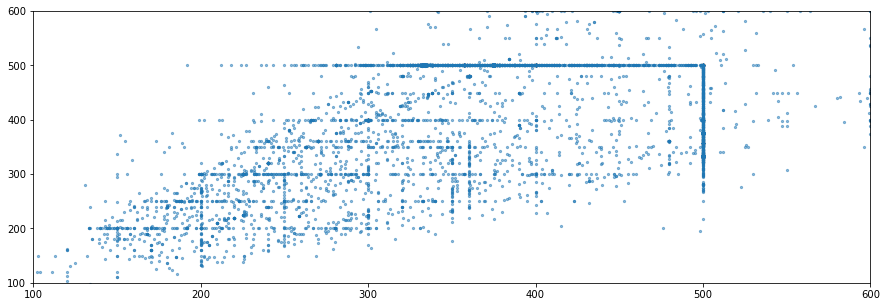

In [9]:
height = []
width = []
for img in imgs:
    height.append(img.shape[0])
    width.append(img.shape[1])
print("Height * Width (Average): %.2f * %.2f" % (np.average(height), np.average(width)))
plt.figure(figsize=[15, 5])
plt.scatter(height, width, s=5, alpha=0.5)
plt.xlim([100, 600])
plt.ylim([100, 600])
plt.show()

In [73]:
shape = 299
train = np.zeros((train_size, shape, shape, 3), dtype=np.uint8)
test = np.zeros((test_size, shape, shape, 3), dtype=np.uint8)
for i in tqdm(range(train_size)):
    img = cv2.imread('./train/%s.jpg' % labels['id'][i])
    img = cv2.resize(img, dsize=(shape, shape))
    img = img[:, :, ::-1]
    train[i] = img
    
for i in tqdm(range(test_size)):
    img = cv2.imread('./test/%s.jpg' % test_labels['id'][i])
    img = cv2.resize(img, dsize=(shape, shape))
    img = img[:, :, ::-1]
    test[i] = img

100%|█████████████████████████████████████████████████████| 10357/10357 [00:51<00:00, 199.78it/s]


In [74]:
print('Training Data Size = %.2f GB' % (sys.getsizeof(train)/1024**3))
print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))

Training Data Size = 2.55 GB
Testing Data Size = 2.59 GB


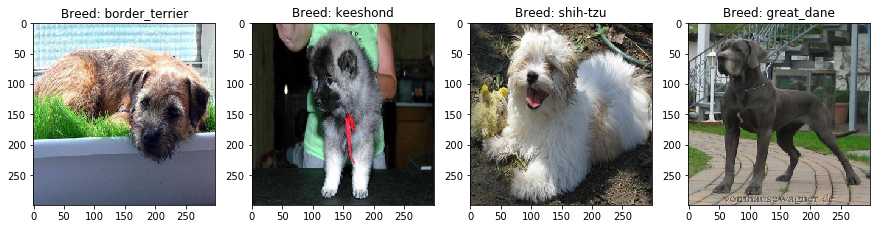

In [10]:
rand_size = 4
rand_id = np.random.choice(range(train_size), rand_size)
plt.figure(figsize=(15, 5))
for i in range(rand_size):
    plt.subplot(1, rand_size, i + 1)
    plt.imshow(train[rand_id[i]])
    plt.title("Breed: %s" % labels['breed'][rand_id[i]])
plt.show()

## 3. 预训练模型 Fine-tune

#### 具体操作流程

- 导入预训练模型
- 冻结全部卷积层，训练全链接层，对模型能达到的水平进行摸底：InceptionV3模型参数有2千万。
- 冻结卷积层的绝大部分，训练卷积层的最后几层以及全连接层
- 特别要注意，batch_size需要比正常训练时选的小的多：`128 -> 16` （否则模型的收敛速度会非常慢）

#### 模型能力

- InceptionV3 训练10代 Loss = 0.6338

In [119]:
pre = Input(shape=(299, 299, 3))
# pre = Lambda(inception_v3.preprocess_input)(pre)
base_model_inception = InceptionV3(include_top=False, input_tensor=pre, weights='imagenet', pooling='avg')
for layer in base_model_inception.layers:
    layer.trainable = False
y = Dropout(0.2)(base_model_inception.output)
y = Dense(120, activation='softmax', kernel_initializer='he_normal')(y)
model_inception = Model(inputs=base_model_inception.input, outputs=y, name='Transfer_Learning_Inception')
# model_inception = make_parallel(model_inception, 2)
model_inception.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# model_inception.summary()

In [120]:
X_train, X_val, y_train, y_val = train_test_split(train, Y_train, shuffle=True, test_size=0.2, random_state=42)
print(X_train.shape)

(8177, 299, 299, 3)


In [121]:
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint


log_dir = datetime.now().strftime('transfer_model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + '\\DogBreed-EP{epoch:02d}-LOSS{val_loss:.4f}.h5', 
                     monitor='val_loss', save_best_only=True)

model_inception.fit(x=X_train, 
                    y=y_train, 
                    batch_size=16, 
                    epochs=10, 
                    validation_data=(X_val, y_val), 
                    callbacks=[es, mc])

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 94s - loss: 3.0190 - acc: 0.4606 - val_loss: 1.7170 - val_acc: 0.7355
Epoch 2/10
8177/8177 [==============================] - 61s - loss: 1.4811 - acc: 0.7203 - val_loss: 0.9944 - val_acc: 0.7966
Epoch 3/10
8177/8177 [==============================] - 61s - loss: 1.0195 - acc: 0.7742 - val_loss: 0.7583 - val_acc: 0.8083
Epoch 4/10
8177/8177 [==============================] - 61s - loss: 0.8457 - acc: 0.7943 - val_loss: 0.6807 - val_acc: 0.8127
Epoch 5/10
8177/8177 [==============================] - 61s - loss: 0.7521 - acc: 0.8009 - val_loss: 0.6184 - val_acc: 0.8244
Epoch 6/10
8177/8177 [==============================] - 61s - loss: 0.6975 - acc: 0.8101 - val_loss: 0.5872 - val_acc: 0.8259
Epoch 7/10
8177/8177 [==============================] - 61s - loss: 0.6526 - acc: 0.8222 - val_loss: 0.5697 - val_acc: 0.8259
Epoch 8/10
8177/8177 [==============================] - 62s - loss: 0.

## 4. 预训练模型导出特征向量

#### 具体操作流程

- 用每个预训练模型（仅使用卷积层部分）对训练集和测试集的图片进行特征提取
- 将计算得到的特征向量导出为文件方便后期直接调用
- 从文件导入特征向量，将不同模型的特征向量以串联方式融合为一个特征向量：np.concatenate(xxx, axis=1)

In [11]:
import h5py
from keras.applications import inception_v3, xception, resnet50, vgg16, vgg19
from keras.applications import InceptionV3, Xception, ResNet50, VGG16, VGG19
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda

def export_gap(MODEL, train, test, preprocess=None):
    x = Input((shape, shape, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(train, batch_size=128)
    test_gap = model.predict(test, batch_size=128)
    
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset('train', data=train_gap)
        f.create_dataset('test', data=test_gap)

Using TensorFlow backend.


In [51]:
export_gap(InceptionV3, train, test, preprocess=inception_v3.preprocess_input)

In [14]:
export_gap(Xception, train, test, preprocess=xception.preprocess_input)

In [45]:
export_gap(ResNet50, train, test)

In [37]:
export_gap(VGG19, train, test)

## 5. 定义及训练融合模型

#### 具体流程

- 从文件导入每个预训练模型计算得到的特征向量，串联在一起作为新模型的输入
- 将输入划分为训练集和验证集，以便在训练时了解模型收敛情况
- 新模型只是Dropout级联一个全链接层（120类的分类器）
- 训练模型：使用ModelCheckpoint和EarlyStopping帮助记录模型最佳收敛状态

#### 模型能力

- InceptionV3 单独可以达到 Loss = 0.2800
- Xception 单独可以达到 Loss = 0.2750
- InceptionV3 + Xception 可以达到 Loss = 0.2400

In [108]:
train_gap = []
test_gap = []
# 'gap_InceptionV3.h5', 'gap_Xception.h5', 'gap_ResNet50.h5', 'gap_VGG16.h5', 'gap_VGG19.h5'
for gapfile in ['gap_InceptionV3.h5','gap_Xception.h5']:
    with h5py.File(gapfile, 'r') as f:
        train_gap.append(np.array(f['train']))
        test_gap.append(np.array(f['test']))
        
print('Feature Vector Shape for Model #0:', train_gap[0].shape)
X_train = np.concatenate(train_gap, axis=1)
X_test = np.concatenate(test_gap, axis=1)
print('Feature Vector Shape after model fusion:', X_train.shape)

Feature Vector Shape for Model #0: (10222, 2048)
Feature Vector Shape after model fusion: (10222, 4096)


In [109]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, shuffle=True, test_size=0.2, random_state=42)
print(X_train.shape)

(8177, 4096)


In [110]:
inputs = Input(shape=(X_train.shape[1],))
y = Dropout(0.2)(inputs)
y = Dense(120, activation='softmax', kernel_initializer='he_normal')(y)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model_fusion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 120)               491640    
Total params: 491,640
Trainable params: 491,640
Non-trainable params: 0
_________________________________________________________________


In [111]:
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

log_dir = datetime.now().strftime('model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + '\\DogBreed-EP{epoch:02d}-LOSS{val_loss:.4f}.h5', 
                     monitor='val_loss', save_best_only=True)
model_fusion.fit(x=X_train, y=y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[es, mc])

Train on 8177 samples, validate on 2045 samples
Epoch 1/50
8177/8177 [==============================] - 2s - loss: 1.9054 - acc: 0.7340 - val_loss: 0.6506 - val_acc: 0.9046
Epoch 2/50
8177/8177 [==============================] - 0s - loss: 0.4487 - acc: 0.9197 - val_loss: 0.3822 - val_acc: 0.9159
Epoch 3/50
8177/8177 [==============================] - 0s - loss: 0.2993 - acc: 0.9327 - val_loss: 0.3153 - val_acc: 0.9149
Epoch 4/50
8177/8177 [==============================] - 0s - loss: 0.2431 - acc: 0.9395 - val_loss: 0.2829 - val_acc: 0.9178
Epoch 5/50
8177/8177 [==============================] - 0s - loss: 0.2122 - acc: 0.9472 - val_loss: 0.2667 - val_acc: 0.9193
Epoch 6/50
8177/8177 [==============================] - 0s - loss: 0.1904 - acc: 0.9478 - val_loss: 0.2550 - val_acc: 0.9193
Epoch 7/50
8177/8177 [==============================] - 0s - loss: 0.1749 - acc: 0.9512 - val_loss: 0.2522 - val_acc: 0.9218
Epoch 8/50
8177/8177 [==============================] - 0s - loss: 0.1619 - a

## 6. 导出测试集结果

#### 基本流程

- 使用融合模型对测试集的特征向量进行预测
- 将结果写入test_lables表中，存为csv文件以供上传。

In [112]:
model_fusion.load_weights('./model_20171012_2037/DogBreed-EP15-LOSS0.2345.h5')

In [113]:
y_test = model_fusion.predict(X_test)
# y_test = np.clip(y_test, 0.005, 0.995)

In [64]:
# 预测出的结果
y_test[0]

array([  6.67974655e-06,   3.84576015e-06,   2.01206626e-06,
         7.32016019e-07,   5.83022143e-07,   4.74610175e-07,
         4.36434874e-07,   6.54450048e-07,   9.32508556e-07,
         5.54240330e-07,   7.76334218e-07,   2.02394631e-06,
         1.53823282e-06,   5.76196253e-05,   7.85863051e-07,
         1.76292497e-06,   2.78800826e-06,   7.29680778e-08,
         2.89845343e-06,   1.56547303e-05,   1.10771612e-06,
         3.28671854e-06,   8.16470583e-06,   6.11307371e-07,
         2.08902588e-06,   8.04837669e-07,   7.32084047e-08,
         4.23010420e-07,   2.22848982e-07,   1.34018392e-05,
         1.83053328e-06,   1.70587214e-06,   2.54876409e-06,
         1.74311435e-06,   9.99803319e-07,   2.12558803e-07,
         2.63765014e-06,   6.00719204e-07,   1.26225575e-06,
         1.25320696e-06,   1.81215114e-06,   1.71206352e-06,
         4.05426135e-06,   2.50098083e-06,   1.22859160e-06,
         4.78863694e-06,   5.68408495e-07,   8.30288513e-07,
         5.90082607e-07,

In [114]:
test_labels.iloc[:, 1:] = y_test

In [115]:
test_labels.to_csv('results.csv', index=False)